# Training Data

In this notebook, I will try to assemble training data pairs: Input subjects from the Radio Galaxy Zoo database and potential hosts from the associated IR image, and output classifications.

In [23]:
import os.path
import pprint
import sys

import astropy.io.fits
import matplotlib.colors
import matplotlib.pyplot
import numpy
import pymongo
import requests
import scipy.ndimage.filters
import sklearn.decomposition
import sklearn.linear_model

sys.path.insert(1, '..')
import crowdastro.rgz_analysis.consensus

%matplotlib inline
matplotlib.pyplot.rcParams['image.cmap'] = 'gray'

HOST = 'localhost'
PORT = 27017
DB_NAME = 'radio'

DATA_PATH = os.path.join('..', 'data')
ATLAS_CATALOGUE_PATH = os.path.join(DATA_PATH, 'ATLASDR3_cmpcat_23July2015.dat')
TILE_SIZE = '2x2'

FITS_IMAGE_WIDTH = 200
FITS_IMAGE_HEIGHT = 200

CLICK_IMAGE_WIDTH = 500
CLICK_IMAGE_HEIGHT = 500

CLICK_TO_FITS_X = FITS_IMAGE_WIDTH / CLICK_IMAGE_WIDTH
CLICK_TO_FITS_Y = FITS_IMAGE_HEIGHT / CLICK_IMAGE_HEIGHT
CLICK_TO_FITS = numpy.array([CLICK_TO_FITS_X, CLICK_TO_FITS_Y])

# Setup Mongo DB.
client = pymongo.MongoClient(HOST, PORT)
db = client[DB_NAME]

## "Simple" subjects

My first task is to screen out what I think would be a simple set of subjects. In the fits-format notebook, I found that about 30% of ATLAS subjects have just one set of radio contours.

I want to screen out all of these and use them as the training subjects. It's a lot easier to look for just the subjects that have `contour_count = 1` &mdash; the number of contours seems to be mostly unrelated to the number of radio sources, but if there's only one contour, there should only be one source. The benefit of doing things this way is that I can ignore the classifications collection for a bit.

In [24]:
subjects = db.radio_subjects.find({'metadata.survey': 'atlas', 'state': 'complete', 'metadata.contour_count': 1})
print('Found {} subjects.'.format(subjects.count()))

Found 128 subjects.


That's a lot less than ideal (and less than expected) but we can fix this later. Let's have a look at some.

In [25]:
def open_fits(subject, field, wavelength):
    """Opens a FITS image.
    
    subject: RGZ subject.
    field: 'elais' or 'cdfs'.
    wavelength: 'ir' or 'radio'.
    -> FITS image file handle.
    """
    if field not in {'elais', 'cdfs'}:
        raise ValueError('field must be either "elais" or "cdfs".')

    if wavelength not in {'ir', 'radio'}:
        raise ValueError('wavelength must be either "ir" or "radio".')
    
    assert subject['metadata']['survey'] == 'atlas', 'Subject not from ATLAS survey.'

    cid = subject['metadata']['source']
    filename = '{}_{}.fits'.format(cid, wavelength)
    path = os.path.join(DATA_PATH, field, TILE_SIZE, filename)
    
    return astropy.io.fits.open(path, ignore_blank=True)

def plot_contours(subject, colour='green'):
    uri = subject['location']['contours']
    contours = requests.get(uri).json()['contours']
    for row in contours:
        for col in row:
            xs = []
            ys = []
            for pair in col['arr']:
                xs.append(pair['x'])
                ys.append(pair['y'])
            matplotlib.pyplot.plot(xs, FITS_IMAGE_HEIGHT - numpy.array(ys), c=colour)

def imshow(im, contrast=0.05):
    """Helper function for showing an image."""
    im = im - im.min() + contrast
    return matplotlib.pyplot.imshow(im,
            origin='lower',
            norm=matplotlib.colors.LogNorm(
                    vmin=im.min(),
                    vmax=im.max(),
            ),
    )

def show_subject(subject):
    with open_fits(subject, 'cdfs', 'ir') as fits_file:
        ir = fits_file[0].data
    
    with open_fits(subject, 'cdfs', 'radio') as fits_file:
        radio = fits_file[0].data
    
    matplotlib.pyplot.figure(figsize=(15, 15))
    matplotlib.pyplot.subplot(1, 2, 1)
    matplotlib.pyplot.title(subject['zooniverse_id'] + ' IR')
    matplotlib.pyplot.xlim((0, FITS_IMAGE_WIDTH))
    matplotlib.pyplot.ylim((0, FITS_IMAGE_HEIGHT))
    imshow(ir)
    plot_contours(subject)
    matplotlib.pyplot.subplot(1, 2, 2)
    matplotlib.pyplot.title(subject['zooniverse_id'] + ' Radio')
    matplotlib.pyplot.xlim((0, FITS_IMAGE_WIDTH))
    matplotlib.pyplot.ylim((0, FITS_IMAGE_HEIGHT))
    imshow(radio)
    plot_contours(subject)

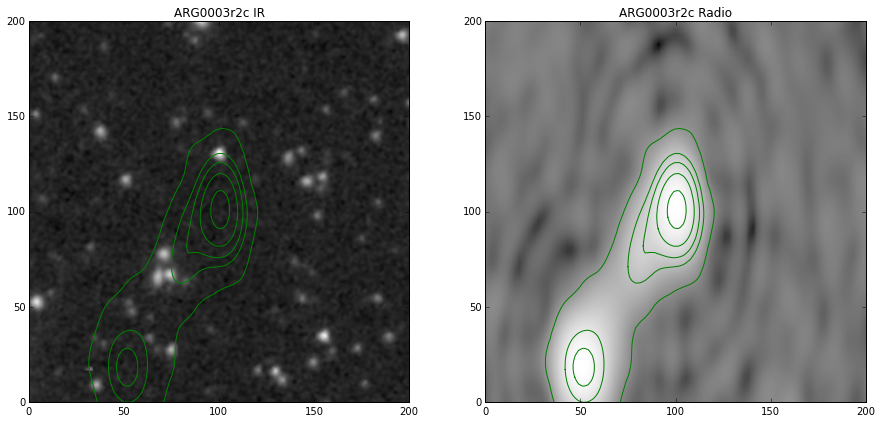

In [26]:
show_subject(subjects[10])

## Potential hosts

Since we're representing this as a binary classification problem, let's get all the potential hosts in an image using the method from the potential_host_counting notebook. This is not ideal &mdash; it includes far too many hosts &mdash; but it'll do for now.

In [27]:
def potential_hosts(subject, sigma=0.5, threshold=0):
    with open_fits(subject, 'cdfs', 'ir') as fits_file:
        ir = fits_file[0].data

    neighborhood = numpy.ones((10, 10))
    blurred_ir = scipy.ndimage.filters.gaussian_filter(ir, sigma) > threshold
    local_max = scipy.ndimage.filters.maximum_filter(blurred_ir, footprint=neighborhood) == blurred_ir
    region_labels, n_labels = scipy.ndimage.measurements.label(local_max)
    maxima = numpy.array(
            [numpy.array((region_labels == i + 1).nonzero()).T.mean(axis=0)
             for i in range(n_labels)]
    )
    maxima = maxima[numpy.logical_and(maxima[:, 1] != 0, maxima[:, 1] != 499)]
    return maxima

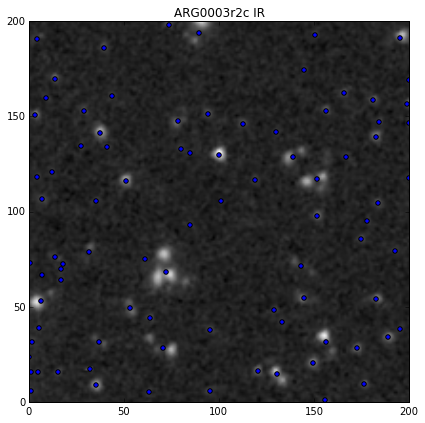

In [28]:
with open_fits(subjects[10], 'cdfs', 'ir') as fits_file:
        ir = fits_file[0].data

matplotlib.pyplot.figure(figsize=(15, 15))
matplotlib.pyplot.subplot(1, 2, 1)
matplotlib.pyplot.title(subjects[10]['zooniverse_id'] + ' IR')
matplotlib.pyplot.xlim((0, FITS_IMAGE_WIDTH))
matplotlib.pyplot.ylim((0, FITS_IMAGE_HEIGHT))
imshow(ir)

maxima = potential_hosts(subjects[10], sigma=1, threshold=0.05)
matplotlib.pyplot.scatter(maxima[:, 1], maxima[:, 0])

matplotlib.pyplot.show()

This is not a fantastic result, but it will do for now. Julie said that the rgz-analysis code found peaks through Gaussian fitting. I can't find the code for that, but I can use the idea later to get better potential hosts.

## Crowdsourced labels

We also need to retrieve the labels for each subject. I'll use the rgz_analysis.consensus code for that.

In [29]:
def crowdsourced_label(subject):
    answers = crowdastro.rgz_analysis.consensus.consensus(subject['zooniverse_id'])['answer']
    answer = [answer for answer in answers.values() if answer['ind'] == 0][0]
    
    if 'ir' in answer:
        return answer['ir']
    
    if 'ir_peak' in answer:
        return answer['ir_peak']
    
    return None

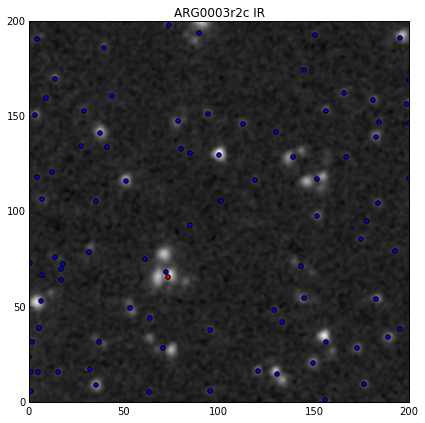

In [30]:
with open_fits(subjects[10], 'cdfs', 'ir') as fits_file:
    ir = fits_file[0].data

matplotlib.pyplot.figure(figsize=(15, 15))
matplotlib.pyplot.subplot(1, 2, 1)
matplotlib.pyplot.title(subjects[10]['zooniverse_id'] + ' IR')
matplotlib.pyplot.xlim((0, FITS_IMAGE_WIDTH))
matplotlib.pyplot.ylim((0, FITS_IMAGE_HEIGHT))
imshow(ir)

maxima = potential_hosts(subjects[10], sigma=1, threshold=0.05)
matplotlib.pyplot.scatter(maxima[:, 1], maxima[:, 0])

label = crowdsourced_label(subjects[10])
# Clicks are upside-down, whereas the image and peaks found from it are not.
matplotlib.pyplot.scatter([CLICK_TO_FITS_X * label[0]], [FITS_IMAGE_HEIGHT - CLICK_TO_FITS_Y * label[1]], c='r')

matplotlib.pyplot.show()

That seems a reasonable answer.

## Assembling the data

We now have
- IR images
- Radio contours
- Radio images
- A single point to classify
- A way to label the points

That's effectively all we need. I want to throw all of this into logistic regression. What I'll do is get a neighbourhood of pixels around the potential host, do the same for the radio image, and naïvely throw it all into scikit-learn. This will almost certainly be ineffective, but it's a start.

In [31]:
def get_training_pairs(subject):
    with open_fits(subject, 'cdfs', 'ir') as fits_file:
        ir = fits_file[0].data

    with open_fits(subject, 'cdfs', 'radio') as fits_file:
        radio = fits_file[0].data
    
    radius = 20
    ir = numpy.pad(ir, radius, mode='linear_ramp')
    radio = numpy.pad(radio, radius, mode='linear_ramp')

    hosts = potential_hosts(subject, sigma=1, threshold=0.05)

    actual_host = crowdsourced_label(subject)

    if actual_host is None:
        return []

    actual_host = numpy.array(actual_host) * CLICK_TO_FITS

    nearest_host = min(hosts, key=lambda host: numpy.hypot(actual_host[0] - host[1], actual_host[1] - host[0]))
    
    pairs = []
    for host in hosts:
        host_y, host_x = host
        ir_neighbourhood = ir[host_x : host_x + 2 * radius, host_y : host_y + 2 * radius]
        radio_neighbourhood = radio[int(host_x) : int(host_x) + 2 * radius, int(host_y) : int(host_y) + 2 * radius]
        input_vec = numpy.concatenate([numpy.ndarray.flatten(ir_neighbourhood), numpy.ndarray.flatten(radio_neighbourhood)])
        label = (nearest_host == host).all()
        pairs.append((input_vec, label))
        
    return pairs

In [32]:
training_data = [pair for subject in subjects for pair in get_training_pairs(subject)]

In [33]:
print('Number of training samples:', len(training_data))

Number of training samples: 9396


## Training

Here, I throw the data into logistic regression and see what happens.

In [34]:
xs = [x for x, _ in training_data]
ys = [int(y) * 2 - 1 for _, y in training_data]

xs_train, xs_test, ys_train, ys_test = sklearn.cross_validation.train_test_split(xs, ys, test_size=0.2, random_state=0)

In [36]:
lr = sklearn.linear_model.LogisticRegression(C=1e5, class_weight='auto')  # Note - auto deprecated from 0.17.
lr.fit(xs_train, ys_train)

LogisticRegression(C=100000.0, class_weight='auto', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0)

In [37]:
n_true_positive = numpy.logical_and(lr.predict(xs_test) == numpy.array(ys_test), numpy.array(ys_test) == 1).sum()
n_true_negative = numpy.logical_and(lr.predict(xs_test) == numpy.array(ys_test), numpy.array(ys_test) == -1).sum()
n_false_positive = numpy.logical_and(lr.predict(xs_test) != numpy.array(ys_test), numpy.array(ys_test) == -1).sum()
n_false_negative = numpy.logical_and(lr.predict(xs_test) != numpy.array(ys_test), numpy.array(ys_test) == 1).sum()

print('True positives:', n_true_positive)
print('True negatives:', n_true_negative)
print('False positives:', n_false_positive)
print('False negatives:', n_false_negative)

True positives: 25
True negatives: 1396
False positives: 454
False negatives: 5


Originally, the logistic regression had essentially learned to output `False`, which makes sense &mdash; the examples are overwhelmingly `False`, so you can get to a very easy minimum by always outputting `False`. I said that some ways to get around this might be to inflate the number of `True` examples, or to change the output encoding in some way. Cheng suggested just weighting logistic regression's cost function to balance the `True`s and `False`s &mdash; there's an argument for this. The result is that there are far more attempts to assign `True`.

In [38]:
print((lr.predict(xs_test) == numpy.array(ys_test)).sum() / len(xs_test))

0.75585106383
